<a href="https://colab.research.google.com/github/ArunK-ML/Project---TripFare-Predicting-Urban-Taxi-Fare-with-Machine-Learning/blob/main/TripFare_ML_After_mind-overload.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚗 **TripFare : Predicting Urban Taxi Fare with Machine Learning**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Collection

df = pd.read_csv("/content/drive/MyDrive/DataSet_For DS/taxi_fare.csv")
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,-73.976746,40.765152,1,N,-74.004265,40.746128,1,9.0,0.5,0.5,2.05,0.00,0.3,12.35
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,-73.983482,40.767925,1,N,-74.005943,40.733166,1,11.0,0.5,0.5,3.05,0.00,0.3,15.35
2,2,2016-03-01 00:00:00,2016-03-01 00:31:06,2,-73.782021,40.644810,1,N,-73.974541,40.675770,1,54.5,0.5,0.5,8.00,0.00,0.3,63.80
3,2,2016-03-01 00:00:00,2016-03-01 00:00:00,3,-73.863419,40.769814,1,N,-73.969650,40.757767,1,31.5,0.0,0.5,3.78,5.54,0.3,41.62
4,2,2016-03-01 00:00:00,2016-03-01 00:00:00,5,-73.971741,40.792183,3,N,-74.177170,40.695053,1,98.0,0.0,0.0,0.00,15.50,0.3,113.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212340,2,2016-03-01 12:15:37,2016-03-01 12:38:53,1,-73.955688,40.782261,1,N,-73.974915,40.751282,1,16.0,0.0,0.5,3.36,0.00,0.3,20.16
212341,2,2016-03-01 12:15:37,2016-03-01 12:38:22,1,-74.002197,40.715042,1,N,-73.976295,40.739609,1,15.5,0.0,0.5,2.00,0.00,0.3,18.30
212342,2,2016-03-01 12:15:37,2016-03-01 12:18:18,1,-73.991173,40.733170,1,N,-73.994324,40.728531,1,4.0,0.0,0.5,0.00,0.00,0.3,4.80
212343,1,2016-03-01 12:15:38,2016-03-01 12:22:47,2,-73.972099,40.786446,1,N,-73.955872,40.779755,2,7.0,0.0,0.5,0.00,0.00,0.3,7.80


In [3]:
df.shape

(212345, 18)

In [4]:
# --------------------------
# 2. Structure & Schema
# --------------------------
print("\n--- Data Types ---")
print(df.dtypes)

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Duplicate Rows ---")
print(df.duplicated().sum())


--- Data Types ---
VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

--- Missing Values ---
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                   

In [5]:
# Change dtype

df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

In [6]:
# Haversine formula function
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Apply to your DataFrame
df["trip_distance_km"] = haversine_distance(
    df["pickup_latitude"],
    df["pickup_longitude"],
    df["dropoff_latitude"],
    df["dropoff_longitude"]
)


In [9]:

# Calculate trip duration in minutes
df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Binary flag for night trips (Yes if 10 PM to 5 AM)
df['pickup_is_night'] = df["tpep_pickup_datetime"].dt.hour.apply(
    lambda x: "Yes" if (x >= 22 or x <= 5) else "No"
)

In [10]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_distance_km,trip_duration_min,pickup_is_night
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,-73.976746,40.765152,1,N,-74.004265,40.746128,...,9.0,0.5,0.5,2.05,0.00,0.3,12.35,3.138096,7.916667,Yes
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,-73.983482,40.767925,1,N,-74.005943,40.733166,...,11.0,0.5,0.5,3.05,0.00,0.3,15.35,4.303331,11.100000,Yes
2,2,2016-03-01 00:00:00,2016-03-01 00:31:06,2,-73.782021,40.644810,1,N,-73.974541,40.675770,...,54.5,0.5,0.5,8.00,0.00,0.3,63.80,16.600142,31.100000,Yes
3,2,2016-03-01 00:00:00,2016-03-01 00:00:00,3,-73.863419,40.769814,1,N,-73.969650,40.757767,...,31.5,0.0,0.5,3.78,5.54,0.3,41.62,9.046547,0.000000,Yes
4,2,2016-03-01 00:00:00,2016-03-01 00:00:00,5,-73.971741,40.792183,3,N,-74.177170,40.695053,...,98.0,0.0,0.0,0.00,15.50,0.3,113.80,20.400022,0.000000,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212340,2,2016-03-01 12:15:37,2016-03-01 12:38:53,1,-73.955688,40.782261,1,N,-73.974915,40.751282,...,16.0,0.0,0.5,3.36,0.00,0.3,20.16,3.806279,23.266667,No
212341,2,2016-03-01 12:15:37,2016-03-01 12:38:22,1,-74.002197,40.715042,1,N,-73.976295,40.739609,...,15.5,0.0,0.5,2.00,0.00,0.3,18.30,3.496576,22.750000,No
212342,2,2016-03-01 12:15:37,2016-03-01 12:18:18,1,-73.991173,40.733170,1,N,-73.994324,40.728531,...,4.0,0.0,0.5,0.00,0.00,0.3,4.80,0.580119,2.683333,No
212343,1,2016-03-01 12:15:38,2016-03-01 12:22:47,2,-73.972099,40.786446,1,N,-73.955872,40.779755,...,7.0,0.0,0.5,0.00,0.00,0.3,7.80,1.555737,7.150000,No


In [11]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'trip_distance_km', 'trip_duration_min', 'pickup_is_night'],
      dtype='object')

In [12]:
# Drop the columns

df = df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime',"pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"])


In [13]:
df

,VendorID,passenger_count,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_distance_km,trip_duration_min,pickup_is_night
0,1,1,1,N,1,9.0,0.5,0.5,2.05,0.00,0.3,12.35,3.138096,7.916667,Yes
1,1,1,1,N,1,11.0,0.5,0.5,3.05,0.00,0.3,15.35,4.303331,11.100000,Yes
2,2,2,1,N,1,54.5,0.5,0.5,8.00,0.00,0.3,63.80,16.600142,31.100000,Yes
3,2,3,1,N,1,31.5,0.0,0.5,3.78,5.54,0.3,41.62,9.046547,0.000000,Yes
4,2,5,3,N,1,98.0,0.0,0.0,0.00,15.50,0.3,113.80,20.400022,0.000000,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212340,2,1,1,N,1,16.0,0.0,0.5,3.36,0.00,0.3,20.16,3.806279,23.266667,No
212341,2,1,1,N,1,15.5,0.0,0.5,2.00,0.00,0.3,18.30,3.496576,22.750000,No
212342,2,1,1,N,1,4.0,0.0,0.5,0.00,0.00,0.3,4.80,0.580119,2.683333,No
212343,1,2,1,N,2,7.0,0.0,0.5,0.00,0.00,0.3,7.80,1.555737,7.150000,No


In [29]:
# Calculate the expected total
df['calculated_total'] = (
    df['fare_amount'] +
    df['extra'] +
    df['mta_tax'] +
    df['tip_amount'] +
    df['tolls_amount'] +
    df['improvement_surcharge']
)

# Find mismatches (allowing for floating-point tolerance)
mismatched_rows = df[~np.isclose(df['calculated_total'], df['total_amount'])]

# Store to CSV
mismatched_rows.to_csv("mismatched_rows.csv", index=False)

# Display all mismatches
print("Total mismatches found:", len(mismatched_rows))
print(mismatched_rows.to_string(index=False))

Total mismatches found: 0
Empty DataFrame
Columns: [VendorID, passenger_count, RatecodeID, store_and_fwd_flag, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, trip_distance_km, trip_duration_min, pickup_is_night, calculated_total]
Index: []


In [27]:
# Replace total_amount with calculated_total

df['total_amount'] = df['calculated_total']

In [28]:
# Count zeros and negative values in each column

# Select only numeric columns
numeric_df = df.select_dtypes(include=np.number)

# Count zeros in each column
zero_count = (numeric_df == 0).sum()

# Count negative values in each column
negative_count = (numeric_df < 0).sum()

# Combine results
result = pd.DataFrame({
    'Zero_Count': zero_count,
    'Negative_Count': negative_count
})

print(result)

                       Zero_Count  Negative_Count
VendorID                        0               0
passenger_count                 9               0
RatecodeID                      0               0
payment_type                    0               0
fare_amount                    50             106
extra                      191930              19
mta_tax                       791             101
tip_amount                  73542               4
tolls_amount               200726               0
improvement_surcharge          45             106
total_amount                   34             106
trip_distance_km             2982               0
trip_duration_min             130               1
calculated_total               34             106


In [30]:
df.to_csv("taxi_fare_cleaned_ff.csv")

In [38]:
# Drop rows where fare_amount == 0

df = df[df['fare_amount'] > 0]

# Remove them
df = df[df['passenger_count'] > 0]

# Replace 0 with mean value
df['improvement_surcharge'] = df['improvement_surcharge'].replace(0, df['improvement_surcharge'].mean())

In [39]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=np.number)

# Count zeros in each column
zero_count = (numeric_df == 0).sum()

# Count negative values in each column
negative_count = (numeric_df < 0).sum()

# Combine results
result = pd.DataFrame({
    'Zero_Count': zero_count,
    'Negative_Count': negative_count
})

print(result)

                       Zero_Count  Negative_Count
VendorID                        0               0
passenger_count                 0               0
RatecodeID                      0               0
payment_type                    0               0
fare_amount                     0               0
extra                      191787               0
mta_tax                       736               0
tip_amount                  73385               0
tolls_amount               200569               0
improvement_surcharge           0               0
total_amount                    0               0
trip_distance_km             2970               0
trip_duration_min             126               1
calculated_total                0               0


In [57]:
for col in df.columns:
    unique_vals = df[col].unique()
    print(f"{col} --> {unique_vals[:10]}{'...' if len(unique_vals) > 10 else ''} (Total unique: {len(unique_vals)})")


VendorID --> [1 2] (Total unique: 2)
passenger_count --> [1 2 3 5 6 4] (Total unique: 6)
RatecodeID --> [ 1  3  2  5  4  6 99] (Total unique: 7)
store_and_fwd_flag --> ['N' 'Y'] (Total unique: 2)
payment_type --> [1 2 3 4] (Total unique: 4)
fare_amount --> [ 9.  11.  54.5 31.5 98.  23.5 23.  20.5  5.5  4. ]... (Total unique: 322)
extra --> [0.5 0.  1. ] (Total unique: 3)
mta_tax --> [0.5 0. ] (Total unique: 2)
tip_amount --> [2.05 3.05 8.   3.78 0.   5.06 2.   3.2  2.2  2.06]... (Total unique: 1221)
tolls_amount --> [ 0.    5.54 15.5  12.5  18.04 18.   17.5   2.54 11.08 17.  ]... (Total unique: 109)
improvement_surcharge --> [0.3        0.29998728] (Total unique: 2)
total_amount --> [ 12.35  15.35  63.8   41.62 113.8   30.36  24.3   21.8    8.8   28.  ]... (Total unique: 2747)
trip_distance_km --> [3.13809608e+00 4.30333111e+00 1.66001420e+01 9.04654730e+00
 2.04000222e+01 6.50227291e+00 8.66643007e+03 7.95006572e+00
 8.37394708e-01 7.12431474e+00]... (Total unique: 209191)
trip_durati

# **Outlier Handle**

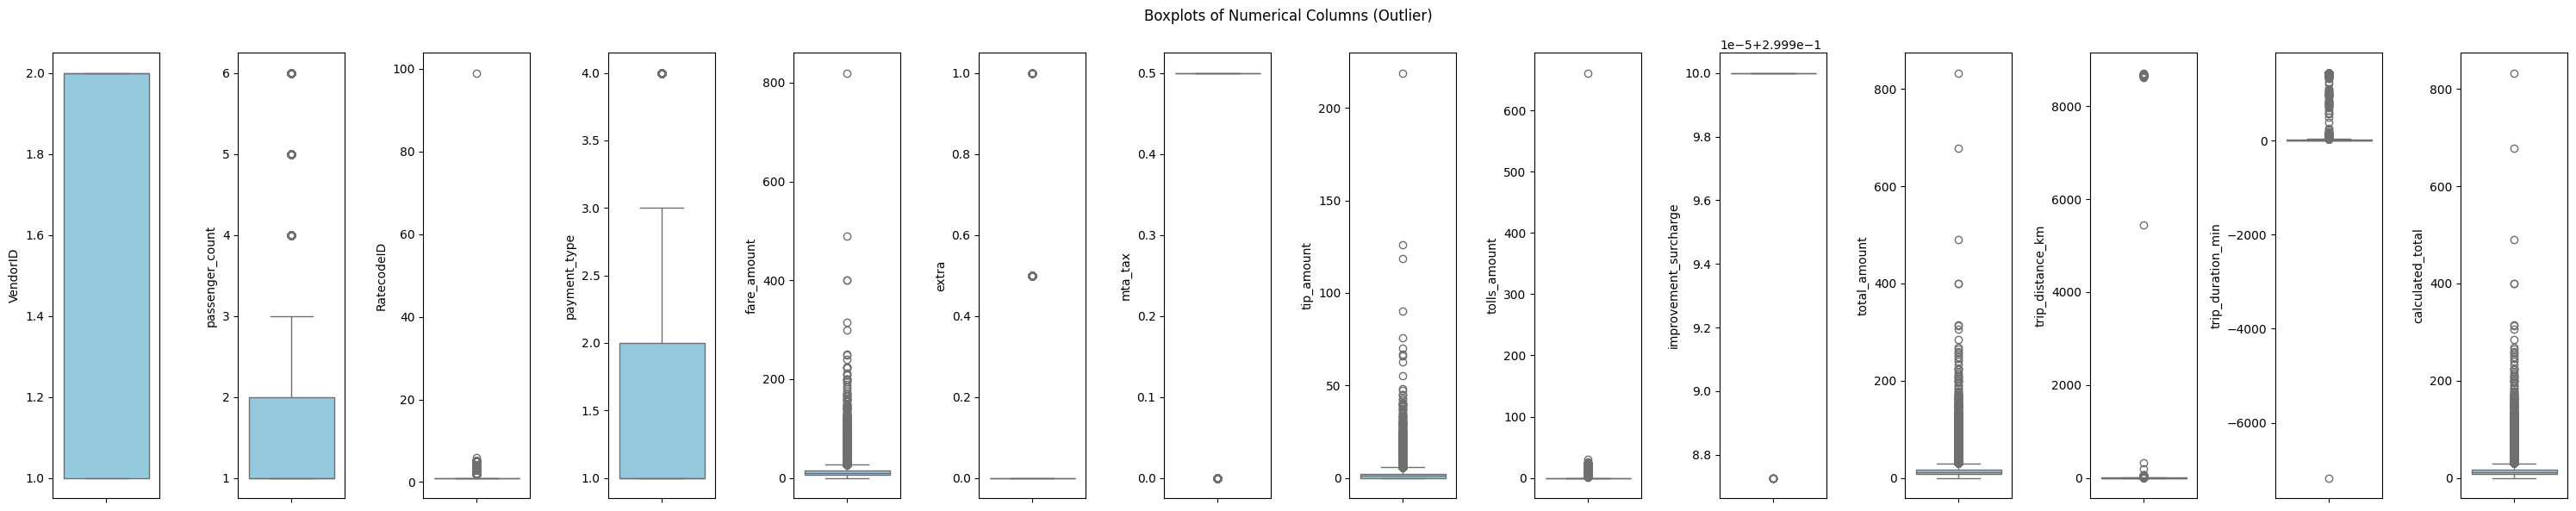

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_cols = df.select_dtypes(exclude='object').columns

# Loop through numerical columns and create boxplots

plt.figure(figsize=(30, 6))
plt.suptitle('Boxplots of Numerical Columns (Outlier)')
for i in range(0, len(numerical_cols)):  # Limit to a maximum of 4 columns
    plt.subplot(1, len(numerical_cols), i+1)
    sns.boxplot(y=df[numerical_cols[i]],color='skyblue',)
    plt.tight_layout()
plt.show()

| Column                     | Outlier Pattern / Issue Observed                 | Possible Cause                         | Suggested Action                  |
| -------------------------- | ------------------------------------------------ | -------------------------------------- | --------------------------------- |
| **VendorID**               | Only 2 values (1 and 2) — no real outliers       | Categorical ID stored as numeric       | Convert to category               |
| **passenger\_count**       | Occasional values >6 (very rare)                 | Data entry errors or unusual cases     | Cap at 6 or review                |
| **RatecodeID**             | Rare extreme value (≈100)                        | Input error                            | Remove or replace                 |
| **payment\_type**          | Few values outside normal range (1–4)            | Wrong codes                            | Map to valid codes                |
| **fare\_amount**           | Extreme highs (>\$800)                           | Long-distance trips or incorrect fares | Winsorize or cap                  |
| **extra**                  | One extreme spike (\~0.5–1 range is normal)      | Manual adjustment or special surcharge | Review & validate                 |
| **mta\_tax**               | Mostly fixed at 0.5, some zeros                  | Possible tax exemption                 | Keep as is                        |
| **tip\_amount**            | Very high tips (> \$200)                         | Rare, possibly data entry error        | Cap at realistic level            |
| **tolls\_amount**          | Some trips with extremely high tolls (> \$500)   | Possibly wrong unit (cents vs dollars) | Validate / correct                |
| **improvement\_surcharge** | Mostly fixed at 0.3, one abnormal value          | Input error                            | Fix to 0.3                        |
| **total\_amount**          | Outliers same as fare\_amount pattern            | Combination of fare & surcharges       | Fix fare, tip, toll → recalc      |
| **trip\_distance\_km**     | Very high values (>8000 km) and many zeros       | GPS errors                             | Cap & set zeros to NaN if invalid |
| **trip\_duration\_min**    | Negative duration and extreme highs (> 5000 min) | Timestamp issues                       | Remove negatives, cap             |
| **calculated\_total**      | Outlier pattern same as total\_amount            | Dependent on other amounts             | Fix source columns                |


In [58]:
import numpy as np

# ---- 1. Convert categorical-like numeric columns ----
df['VendorID'] = df['VendorID'].astype('category')
df['payment_type'] = df['payment_type'].astype('category')
df['RatecodeID'] = df['RatecodeID'].astype('category')


# ---- 2. Fix passenger_count ----
df.loc[df['passenger_count'] > 6, 'passenger_count'] = np.nan  # Cap unrealistic
df.loc[df['passenger_count'] <= 0, 'passenger_count'] = np.nan  # Remove zeros/negatives

# ---- 3. Fix RatecodeID extreme values ----
df.loc[~df['RatecodeID'].isin(['1', '2', '3', '4', '5', '6']), 'RatecodeID'] = np.nan

# ---- 4. Fare amount ----
df.loc[(df['fare_amount'] <= 0) | (df['fare_amount'] > 500), 'fare_amount'] = np.nan

# ---- 5. Extra charges ----
df.loc[df['extra'] > 10, 'extra'] = np.nan  # very high extra
df['extra'] = df['extra'].fillna(0)  # optional fill

# ---- 6. MTA tax ----
df.loc[~df['mta_tax'].isin([0, 0.5]), 'mta_tax'] = 0.5  # correct to standard

# ---- 7. Tip amount ----
df.loc[df['tip_amount'] > 200, 'tip_amount'] = np.nan

# ---- 8. Toll amount ----
df.loc[df['tolls_amount'] > 200, 'tolls_amount'] = np.nan

# ---- 9. Improvement surcharge ----
df.loc[df['improvement_surcharge'] != 0.3, 'improvement_surcharge'] = 0.3

# ---- 10. Total amount ----
df.loc[(df['total_amount'] <= 0) | (df['total_amount'] > 500), 'total_amount'] = np.nan

# ---- 11. Trip distance ----
df.loc[(df['trip_distance_km'] <= 0) | (df['trip_distance_km'] > 100), 'trip_distance_km'] = np.nan

# ---- 12. Trip duration ----
df.loc[(df['trip_duration_min'] <= 0) | (df['trip_duration_min'] > 600), 'trip_duration_min'] = np.nan

# ---- 13. Calculated total ----
df['calculated_total'] = df['fare_amount'].fillna(0) + \
                         df['extra'].fillna(0) + \
                         df['mta_tax'].fillna(0) + \
                         df['tip_amount'].fillna(0) + \
                         df['tolls_amount'].fillna(0) + \
                         df['improvement_surcharge'].fillna(0)

print("Data cleaning complete!")


Data cleaning complete!


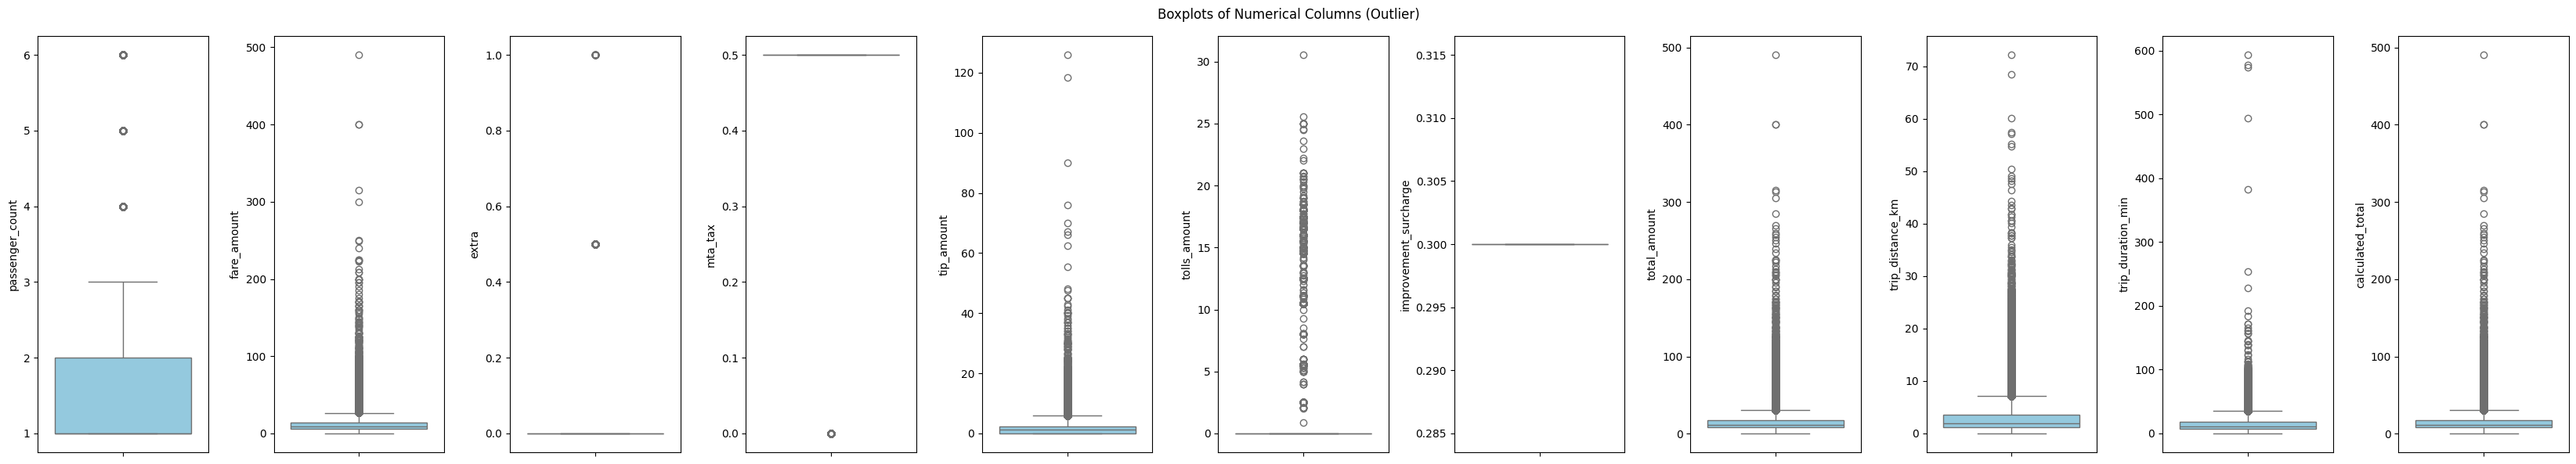

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_cols = df.select_dtypes(include=np.number).columns
n_cols = len(numerical_cols)
# Loop through numerical columns and create boxplots

plt.figure(figsize=(n_cols * 3, 6)) # Adjust figure size based on number of columns
plt.suptitle('Boxplots of Numerical Columns (Outlier)')
for i in range(0, n_cols):
    plt.subplot(1, n_cols, i+1) # Set the number of columns in subplot to n_cols
    sns.boxplot(y=df[numerical_cols[i]],color='skyblue',)
    plt.tight_layout()
plt.show()

In [63]:
import pandas as pd

# Apply IQR method to all numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

df_no_outliers = df.copy()

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Keep only rows without outliers in this column
    df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]

print("Original shape:", df.shape)
print("After removing outliers:", df_no_outliers.shape)


Original shape: (212182, 16)
After removing outliers: (144230, 16)


In [67]:
df = df_no_outliers

# **Null value Handling**

In [68]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=np.number)

# Count zeros in each column
zero_count = (numeric_df == 0).sum()

# Count negative values in each column
negative_count = (numeric_df < 0).sum()

# Combine results
result = pd.DataFrame({
    'Zero_Count': zero_count,
    'Negative_Count': negative_count
})

print(result)

                       Zero_Count  Negative_Count
passenger_count                 0               0
fare_amount                     0               0
extra                      144230               0
mta_tax                         0               0
tip_amount                  49508               0
tolls_amount               144230               0
improvement_surcharge           0               0
total_amount                    0               0
trip_distance_km                0               0
trip_duration_min               0               0
calculated_total                0               0


In [69]:
df.columns

Index(['VendorID', 'passenger_count', 'RatecodeID', 'store_and_fwd_flag',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'trip_distance_km', 'trip_duration_min', 'pickup_is_night',
       'calculated_total'],
      dtype='object')

In [70]:
df.shape

(144230, 16)

In [71]:
from sklearn.preprocessing import LabelEncoder
code = LabelEncoder()

for i in df.select_dtypes(include="object").columns:
  df[i] = code.fit_transform(df[i])

In [72]:
df


,VendorID,passenger_count,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_distance_km,trip_duration_min,pickup_is_night,calculated_total
173,2,1.0,NaN,0,1,6.0,0.0,0.5,1.36,0.0,0.3,8.16,1.279013,5.283333,0,8.16
174,2,2.0,NaN,0,1,13.0,0.0,0.5,1.50,0.0,0.3,15.30,3.755555,15.683333,0,15.30
175,2,2.0,NaN,0,1,8.5,0.0,0.5,1.86,0.0,0.3,11.16,3.251549,6.533333,0,11.16
176,2,1.0,NaN,0,2,15.5,0.0,0.5,0.00,0.0,0.3,16.30,5.794492,15.700000,0,16.30
179,2,1.0,NaN,0,2,6.5,0.0,0.5,0.00,0.0,0.3,7.30,1.706127,6.400000,0,7.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212339,1,1.0,NaN,0,1,18.5,0.0,0.5,3.85,0.0,0.3,23.15,5.778299,21.866667,0,23.15
212340,2,1.0,NaN,0,1,16.0,0.0,0.5,3.36,0.0,0.3,20.16,3.806279,23.266667,0,20.16
212341,2,1.0,NaN,0,1,15.5,0.0,0.5,2.00,0.0,0.3,18.30,3.496576,22.750000,0,18.30
212342,2,1.0,NaN,0,1,4.0,0.0,0.5,0.00,0.0,0.3,4.80,0.580119,2.683333,0,4.80


In [73]:
df = df.drop(columns=["RatecodeID","calculated_total","VendorID"])

In [74]:
df.reset_index(drop=True)

,passenger_count,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_distance_km,trip_duration_min,pickup_is_night
0,1.0,0,1,6.0,0.0,0.5,1.36,0.0,0.3,8.16,1.279013,5.283333,0
1,2.0,0,1,13.0,0.0,0.5,1.50,0.0,0.3,15.30,3.755555,15.683333,0
2,2.0,0,1,8.5,0.0,0.5,1.86,0.0,0.3,11.16,3.251549,6.533333,0
3,1.0,0,2,15.5,0.0,0.5,0.00,0.0,0.3,16.30,5.794492,15.700000,0
4,1.0,0,2,6.5,0.0,0.5,0.00,0.0,0.3,7.30,1.706127,6.400000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144225,1.0,0,1,18.5,0.0,0.5,3.85,0.0,0.3,23.15,5.778299,21.866667,0
144226,1.0,0,1,16.0,0.0,0.5,3.36,0.0,0.3,20.16,3.806279,23.266667,0
144227,1.0,0,1,15.5,0.0,0.5,2.00,0.0,0.3,18.30,3.496576,22.750000,0
144228,1.0,0,1,4.0,0.0,0.5,0.00,0.0,0.3,4.80,0.580119,2.683333,0


In [76]:
df.dtypes

,0
passenger_count,float64
store_and_fwd_flag,int64
payment_type,category
fare_amount,float64
extra,float64
mta_tax,float64
tip_amount,float64
tolls_amount,float64
improvement_surcharge,float64
total_amount,float64


In [83]:
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype('category')
df["pickup_is_night"] = df["pickup_is_night"].astype('category')
df["passenger_count"] = df["passenger_count"].astype('category')

In [84]:
# --------------------------
# 3. Distribution & Skewness
# --------------------------

# Step 1: Select numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns

# Step 2: Loop through numeric columns
for col in numeric_cols:
    skew_val = df[col].skew()
    kurt_val = df[col].kurtosis()

    print(f"\nColumn: {col}")
    print(f"  Skewness: {skew_val:.3f}")
    print(f"  Kurtosis: {kurt_val:.3f}")

    # Step 3: Apply normality check thresholds
    if skew_val < 0.5 and skew_val > -0.5 and kurt_val < 3 and kurt_val > -3:
        print("  ✅ Looks approximately normal")
    else:
        print("  ⚠ Not normal (may need transformation)")


Column: fare_amount
  Skewness: 0.955
  Kurtosis: 0.492
  ⚠ Not normal (may need transformation)

Column: extra
  Skewness: 0.000
  Kurtosis: 0.000
  ✅ Looks approximately normal

Column: mta_tax
  Skewness: 0.000
  Kurtosis: 0.000
  ✅ Looks approximately normal

Column: tip_amount
  Skewness: 0.675
  Kurtosis: -0.094
  ⚠ Not normal (may need transformation)

Column: tolls_amount
  Skewness: 0.000
  Kurtosis: 0.000
  ✅ Looks approximately normal

Column: improvement_surcharge
  Skewness: 0.000
  Kurtosis: 0.000
  ✅ Looks approximately normal

Column: total_amount
  Skewness: 0.956
  Kurtosis: 0.556
  ⚠ Not normal (may need transformation)

Column: trip_distance_km
  Skewness: 1.274
  Kurtosis: 1.310
  ⚠ Not normal (may need transformation)

Column: trip_duration_min
  Skewness: 0.850
  Kurtosis: 0.270
  ⚠ Not normal (may need transformation)


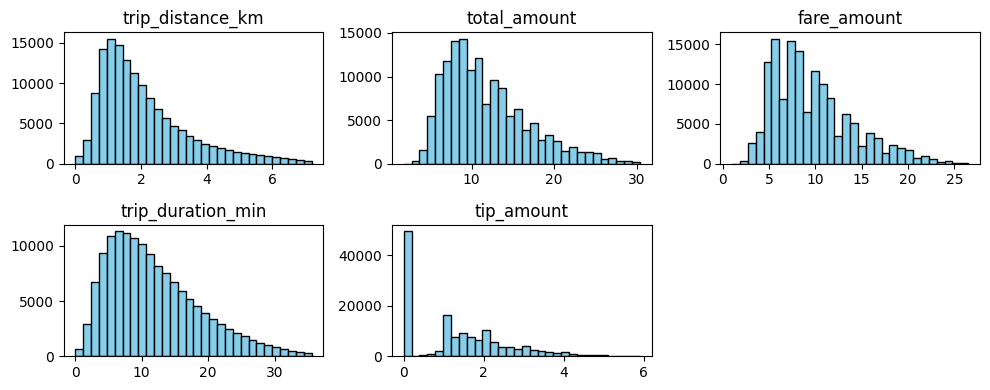

In [85]:
# Select numerical columns with high skewness (absolute skewness > 0.5)
skewness = df.select_dtypes(include=np.number).skew().sort_values(ascending=False)
skewed_cols = skewness[abs(skewness) > 0.5].index

# Plot histograms before transformation
plt.figure(figsize=(10,4))
for i, col in enumerate(skewed_cols, 1):
    plt.subplot(2,3,i)
    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

In [86]:
# Transformation

# Methods (lambda values for Box-Cox)
methods = [0, 0.5, -0.5, -1, 1, 2, -2]

# Loop through numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    print(f"\n=== Column: {col} ===")

    # Box-Cox requires positive values
    if (df[col] <= 0).any():
        print("❌ Skipped (contains zero or negative values)")
        continue

    for j in methods:
        # Apply Box-Cox
        transformed = boxcox(df[col], lmbda=j)

        # Calculate skewness and kurtosis
        skew_val = pd.Series(transformed).skew()
        kurt_val = pd.Series(transformed).kurtosis()

        print(f"λ = {j}:  skew = {skew_val:.3f}, kurtosis = {kurt_val:.3f}")


=== Column: fare_amount ===
λ = 0:  skew = 0.026, kurtosis = -0.567
λ = 0.5:  skew = 0.495, kurtosis = -0.329
λ = -0.5:  skew = -0.476, kurtosis = -0.048
λ = -1:  skew = -1.082, kurtosis = 2.290
λ = 1:  skew = 0.955, kurtosis = 0.492
λ = 2:  skew = 1.883, kurtosis = 3.844
λ = -2:  skew = -4.890, kurtosis = 135.693

=== Column: extra ===
❌ Skipped (contains zero or negative values)

=== Column: mta_tax ===
λ = 0:  skew = 0.000, kurtosis = 0.000
λ = 0.5:  skew = 0.000, kurtosis = 0.000
λ = -0.5:  skew = 0.000, kurtosis = 0.000
λ = -1:  skew = 0.000, kurtosis = 0.000
λ = 1:  skew = 0.000, kurtosis = 0.000
λ = 2:  skew = 0.000, kurtosis = 0.000
λ = -2:  skew = 0.000, kurtosis = 0.000

=== Column: tip_amount ===
❌ Skipped (contains zero or negative values)

=== Column: tolls_amount ===
❌ Skipped (contains zero or negative values)

=== Column: improvement_surcharge ===
λ = 0:  skew = 0.000, kurtosis = 0.000
λ = 0.5:  skew = 0.000, kurtosis = 0.000
λ = -0.5:  skew = 0.000, kurtosis = 0.000
λ

In [88]:
df["fare_amount"] = boxcox(df["fare_amount"], lmbda=0)
df["trip_distance_km"] = boxcox(df["trip_distance_km"], lmbda=0.5)
df["total_amount"] = boxcox(df["total_amount"], lmbda=0)
df["trip_duration_min"] = boxcox(df["trip_duration_min"], lmbda=0)

In [89]:
# Step 2: Loop through numeric columns
for col in numeric_cols:
    skew_val = df[col].skew()
    kurt_val = df[col].kurtosis()

    print(f"\nColumn: {col}")
    print(f"  Skewness: {skew_val:.3f}")
    print(f"  Kurtosis: {kurt_val:.3f}")

    # Step 3: Apply normality check thresholds
    if skew_val < 0.5 and skew_val > -0.5 and kurt_val < 3 and kurt_val > -3:
        print("  ✅ Looks approximately normal")
    else:
        print("  ⚠ Not normal (may need transformation)")


Column: fare_amount
  Skewness: nan
  Kurtosis: nan
  ⚠ Not normal (may need transformation)

Column: extra
  Skewness: 0.000
  Kurtosis: 0.000
  ✅ Looks approximately normal

Column: mta_tax
  Skewness: 0.000
  Kurtosis: 0.000
  ✅ Looks approximately normal

Column: tip_amount
  Skewness: 0.675
  Kurtosis: -0.094
  ⚠ Not normal (may need transformation)

Column: tolls_amount
  Skewness: 0.000
  Kurtosis: 0.000
  ✅ Looks approximately normal

Column: improvement_surcharge
  Skewness: 0.000
  Kurtosis: 0.000
  ✅ Looks approximately normal

Column: total_amount
  Skewness: 0.046
  Kurtosis: -0.515
  ✅ Looks approximately normal

Column: trip_distance_km
  Skewness: 0.557
  Kurtosis: -0.018
  ⚠ Not normal (may need transformation)

Column: trip_duration_min
  Skewness: -0.771
  Kurtosis: 1.818
  ⚠ Not normal (may need transformation)


/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1256: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean
/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1344: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean


# ** Preprocessing**

In [90]:
df.columns

Index(['passenger_count', 'store_and_fwd_flag', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'trip_distance_km',
       'trip_duration_min', 'pickup_is_night'],
      dtype='object')

**Feature Engineering**

In [92]:
from sklearn.preprocessing import LabelEncoder
code = LabelEncoder()

for i in df.select_dtypes(include="object").columns:
  df[i] = code.fit_transform(df[i])

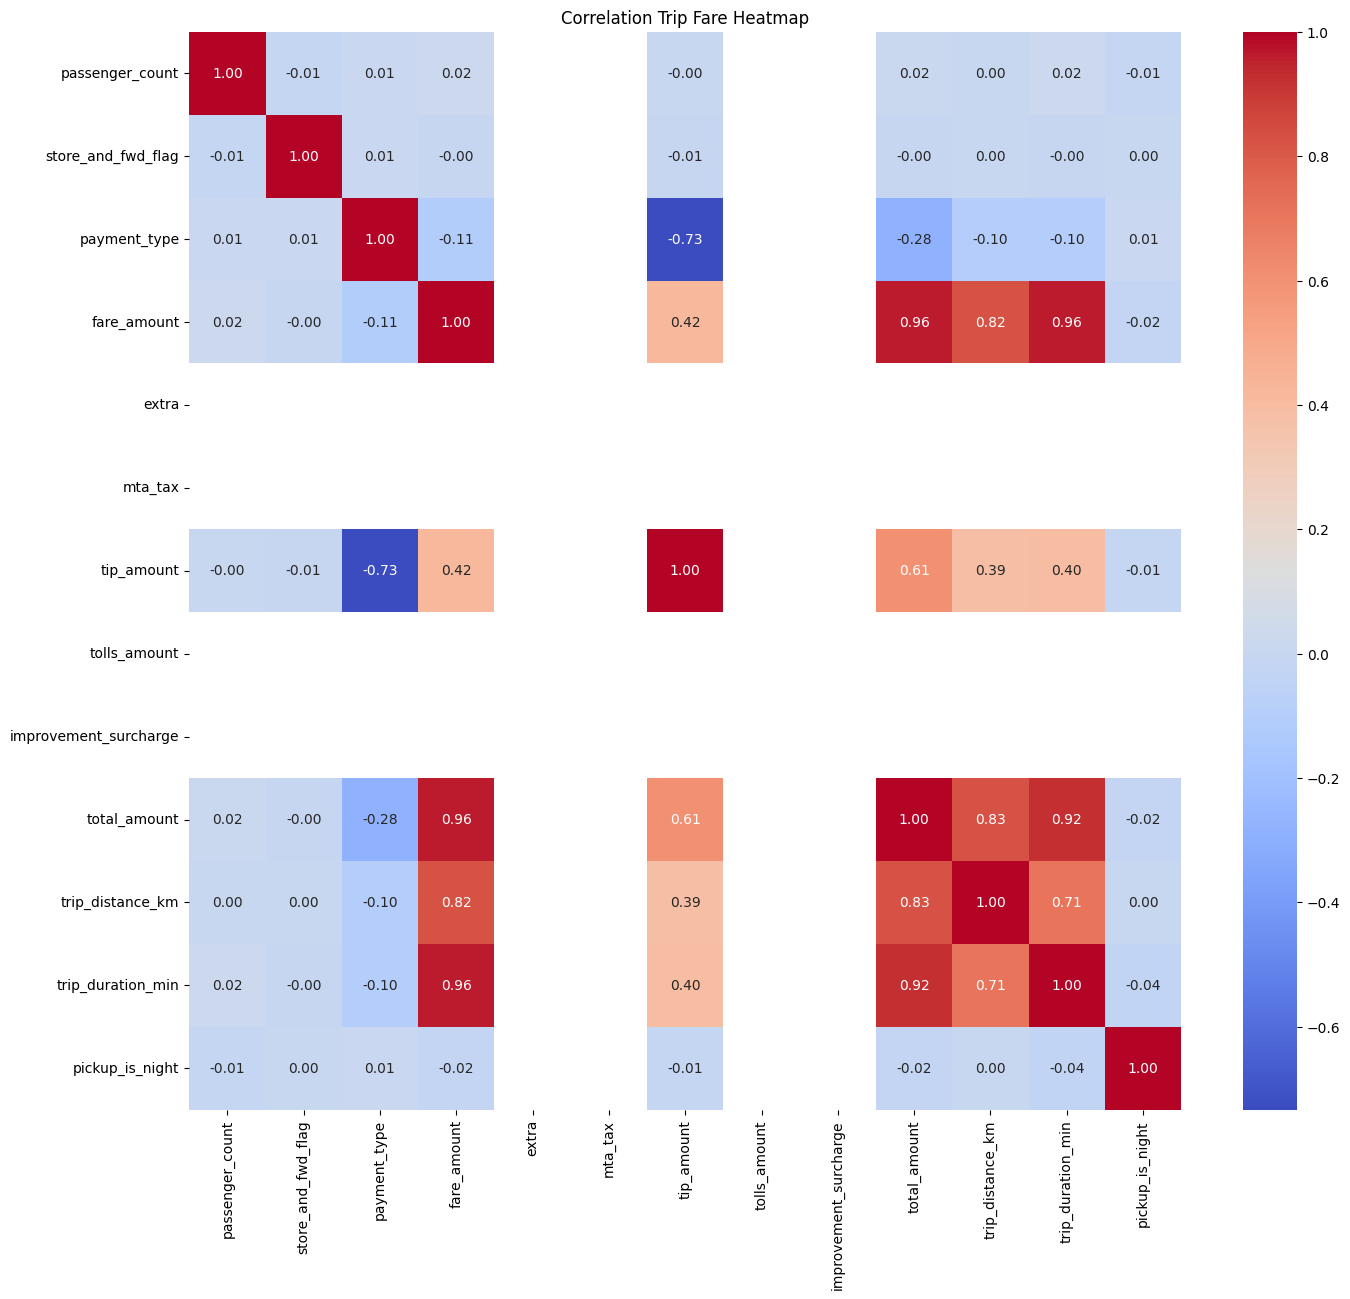

In [93]:

df_copy = df.copy()


# -----------------------------------------------------------------------------
#                               Correlation Test
# ---------------------------------------------------------------------------

import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------------------
# Calculate correlation for Trip Fare
# ----------------------------------------
corr = df_copy.corr()

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Trip Fare Heatmap")
plt.show()



# **Hypothesis testing**

In [96]:
df.dtypes

,0
passenger_count,category
store_and_fwd_flag,category
payment_type,category
fare_amount,float64
extra,float64
mta_tax,float64
tip_amount,float64
tolls_amount,float64
improvement_surcharge,float64
total_amount,float64


In [94]:
df.columns

Index(['passenger_count', 'store_and_fwd_flag', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'trip_distance_km',
       'trip_duration_min', 'pickup_is_night'],
      dtype='object')

In [97]:
continuous = [ 'fare_amount','extra', 'mta_tax', 'tip_amount', 'tolls_amount','improvement_surcharge', 'total_amount', 'trip_distance_km','trip_duration_min']

category = ['passenger_count', 'store_and_fwd_flag', 'payment_type','pickup_is_night']


# **Data Transformation**

In [98]:

from scipy import stats

#continious vs continious
def two_sample(d1,d2):
  t=0
  f=0
  for i in  range(31):
    sample1=d1.sample(frac=0.03)
    sample2=d2.sample(frac=0.03)
    t_test,p_value=stats.ttest_ind(sample1,sample2)
    if p_value < 0.1:
      f=f+1
    else:
      t=t+1
  if t>f:
    return True
  else:
    return False


In [99]:
#cat vs cat
def chisquare_cat_vs_cat(d1,d2):
    return True if stats.chi2_contingency(pd.crosstab(d1,d2))[1] < 0.1 else False

In [100]:
#continious(d1) vs cat(d2)
def annova_test(d1,d2):
    group= df[d2].unique()
    data = {}
    for i in group:
        # Check if the category has more than one data point
        if len(df[d1][df[d2]==i]) > 1:
            data[i]=df[d1][df[d2]==i]
    # Check if there are at least two groups with more than one data point
    if len(data) < 2:
        return False  # Cannot perform ANOVA with less than two groups
    f_value,p_value=stats.f_oneway(*[i for i in data.values()])
    return False if p_value < 0.1 else True


In [101]:
final = {}
for i in df.columns:
    final[i]={}
    for j in df.columns:
        if (i in continuous) and (j in continuous):
            result=two_sample(df[i],df[j])
        elif (i in continuous) and (j in category):
            result=annova_test(i,j)
        elif (i in category) and (j in continuous):
            result=annova_test(j,i)
        elif (i in category) and (j in category):
            result=chisquare_cat_vs_cat(df[i],df[j])
        if result:
            final[i][j]=1
        else:
            final[i][j]=0

/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:3974: RuntimeWarning: invalid value encountered in subtract
  alldata = alldata - offset
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:3982: RuntimeWarning: invalid value encountered in subtract
  smo_ss = _square_of_sums(sample - offset, axis=axis)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:3974: RuntimeWarning: invalid value encountered in subtract
  alldata = alldata - offset
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:3982: RuntimeWarning: invalid value encountered in subtract
  smo_ss = _square_of_sums(sample - offset, axis=axis)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:579: ConstantInputWarning: Each of th

In [102]:
final_df = pd.DataFrame(final)
final_df

,passenger_count,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_distance_km,trip_duration_min,pickup_is_night
passenger_count,1,1,1,1,1,1,1,1,1,0,0,0,1
store_and_fwd_flag,1,1,1,1,1,1,0,1,1,1,1,0,0
payment_type,1,1,1,1,1,1,0,1,1,0,0,0,1
fare_amount,1,1,1,1,0,0,0,0,0,0,1,0,1
extra,1,1,1,0,1,0,0,1,0,0,0,0,1
mta_tax,1,1,1,0,0,1,0,0,0,0,0,0,1
tip_amount,1,0,0,0,0,0,1,0,0,0,0,0,0
tolls_amount,1,1,1,0,1,0,0,1,0,0,0,0,1
improvement_surcharge,1,1,1,0,0,0,0,0,1,0,0,0,1
total_amount,0,1,0,0,0,0,0,0,0,1,0,0,0


<Axes: >

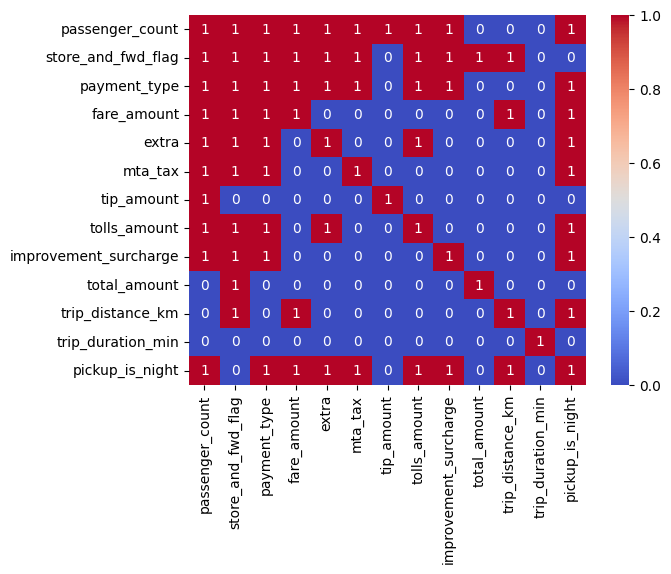

In [103]:
import seaborn as sns
sns.heatmap(final_df,annot=True,cmap="coolwarm")

# **Train the model ML**

In [110]:
for col in df.select_dtypes(include='object').columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

In [111]:
df.columns

Index(['passenger_count', 'store_and_fwd_flag', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'trip_distance_km',
       'trip_duration_min', 'pickup_is_night'],
      dtype='object')

In [117]:
from sklearn.preprocessing import LabelEncoder

# Convert all categorical columns to integer codes
label_encoders = {}
for col in df.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [118]:
df.dtypes

,0
passenger_count,int64
store_and_fwd_flag,int64
payment_type,int64
fare_amount,float64
extra,float64
mta_tax,float64
tip_amount,float64
tolls_amount,float64
improvement_surcharge,float64
total_amount,float64


In [119]:
df

,passenger_count,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_distance_km,trip_duration_min,pickup_is_night
173,0,0,0,0.583198,0.0,0.5,1.36,0.0,0.3,2.099244,0.261869,1.664557,0
174,1,0,0,0.941939,0.0,0.5,1.50,0.0,0.3,2.727853,1.875851,2.752599,0
175,1,0,0,0.760837,0.0,0.5,1.86,0.0,0.3,2.412336,1.606410,1.876917,0
176,0,0,1,1.008264,0.0,0.5,0.00,0.0,0.3,2.791165,2.814350,2.753661,0
179,0,0,1,0.626902,0.0,0.5,0.00,0.0,0.3,1.987874,0.612376,1.856298,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212339,0,0,0,1.070820,0.0,0.5,3.85,0.0,0.3,3.141995,2.807618,3.084963,0
212340,0,0,0,1.019781,0.0,0.5,3.36,0.0,0.3,3.003700,1.901938,3.147022,0
212341,0,0,0,1.008264,0.0,0.5,2.00,0.0,0.3,2.906901,1.739827,3.124565,0
212342,0,0,0,0.326634,0.0,0.5,0.00,0.0,0.3,1.568616,-0.476689,0.987060,0


In [129]:
y = df['fare_amount']
x = df.drop('fare_amount',axis=1)

In [130]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((115384, 12), (28846, 12), (115384,), (28846,))

In [131]:
# Step 1
# Check for infinite values in x_train
print(x_train.columns[np.isinf(x_train).any()])

Index([], dtype='object')


In [133]:
# Step 2 for replacing inf values ,replaced the values by mean()
x_train.replace([np.inf,-np.inf],np.nan,inplace=True)
x_test.replace([np.inf,-np.inf],np.nan,inplace=True)
x_train.fillna(x_train.mean(),inplace=True)
x_test.fillna(x_test.mean(),inplace=True)

In [134]:
# Step 3
# Check for infinite values in x_train
print(x_train.columns[np.isinf(x_train).any()])

Index([], dtype='object')


In [136]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score
import numpy as np # Import numpy for np.inf and np.nan

# Check and replace infinite values in y_train
y_train.replace([np.inf, -np.inf], np.nan, inplace=True)
y_train.fillna(y_train.mean(), inplace=True)

# Check and replace infinite values in y_test (good practice, although the error was on y_train)
y_test.replace([np.inf, -np.inf], np.nan, inplace=True)
y_test.fillna(y_test.mean(), inplace=True)


model = RandomForestRegressor().fit(x_train,y_train)
y_pred = model.predict(x_test)
print(mean_absolute_error(y_test,y_pred))
print(mean_absolute_percentage_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

0.00040430726391763397
0.0011003110315585365
0.00029267961635150505
0.993674710884134


In [ ]:
# Model 1
from sklearn.svm import SVR
model1 = SVR().fit(x_train,y_train)
y_pred = model1.predict(x_test)
print(mean_absolute_error(y_test,y_pred))
print(mean_absolute_percentage_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

In [ ]:
# Model 2
from sklearn.neighbors import KNeighborsRegressor
model2 = KNeighborsRegressor(n_neighbors=3)
model2.fit(x_train,y_train)
y_pred = model2.predict(x_test)
print(mean_absolute_error(y_test,y_pred))
print(mean_absolute_percentage_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

0.6225914503411163
0.2519117331743747
10.675102476198399
0.9045248063776894


In [126]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# Predictions
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Function to print metrics
def print_metrics(y_true, y_pred, dataset_name):
    print(f"\n📊 {dataset_name} Metrics")
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("MAPE:", mean_absolute_percentage_error(y_true, y_pred))
    print("MSE :", mean_squared_error(y_true, y_pred))
    print("R²  :", r2_score(y_true, y_pred))

# Training metrics
print_metrics(y_train, y_train_pred, "Training")

# Test metrics
print_metrics(y_test, y_test_pred, "Test")


📊 Training Metrics
MAE : 3.426914160571457e-05
MAPE: 2.1329294110536e-05
MSE : 2.889646294308907e-06
R²  : 0.9999835508741813

📊 Test Metrics
MAE : 6.674024154928318e-05
MAPE: 3.0163844200020377e-05
MSE : 1.7345471802731452e-06
R²  : 0.9999902144067897


In [137]:
# Make sure the target column is NOT in features
target_col = "fare_amount"
if target_col in x_train.columns:
    print("⚠️ Target column found in training features — possible leakage!")
else:
    print("✅ Target column is not in features.")


✅ Target column is not in features.


In [138]:
import pandas as pd

# Combine features and target for correlation check
df_corr = pd.concat([x_train, y_train], axis=1)

corr_matrix = df_corr.corr()
target_corr = corr_matrix[target_col].drop(target_col)  # Remove self-correlation

print(target_corr.sort_values(ascending=False))

# Flag suspicious correlations
print("Possible leakage columns:", target_corr[target_corr.abs() > 0.99].index.tolist())


trip_duration_min        0.965109
total_amount             0.964892
trip_distance_km         0.824017
tip_amount               0.419537
passenger_count          0.019241
store_and_fwd_flag      -0.003471
pickup_is_night         -0.023597
payment_type            -0.105109
extra                         NaN
mta_tax                       NaN
tolls_amount                  NaN
improvement_surcharge         NaN
Name: fare_amount, dtype: float64
Possible leakage columns: []


In [139]:
df.columns

Index(['passenger_count', 'store_and_fwd_flag', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'trip_distance_km',
       'trip_duration_min', 'pickup_is_night'],
      dtype='object')

In [147]:
import pandas as pd

# Input data with original categorical values
input_data = {
    'passenger_count': [2],      # Original passenger count
    'store_and_fwd_flag': ['N'], # Original categorical value
    'payment_type': [1],        # Original numerical code for payment type
    'extra': [0.5],
    'mta_tax': [0.5],
    'tip_amount': [3.0],
    'tolls_amount': [0.0],
    'improvement_surcharge': [0.3],
    'total_amount': [12.0],
    'trip_distance_km': [5.2],
    'trip_duration_min': [12.0],
    'pickup_is_night': ['No'] # Original categorical value
}

input_df = pd.DataFrame(input_data)


# One-Hot Encode categorical columns in input_df
input_df = pd.get_dummies(input_df, columns=['store_and_fwd_flag', 'pickup_is_night'])

# For 'passenger_count' and 'payment_type', since they were treated as categorical
# and then LabelEncoded, let's convert them to object type first to ensure get_dummies treats them as categories.
input_df['passenger_count'] = input_df['passenger_count'].astype('object')
input_df['payment_type'] = input_df['payment_type'].astype('object')
input_df = pd.get_dummies(input_df, columns=['passenger_count', 'payment_type'])


# Ensure all columns from x_train are present in input_df and in the same order
train_cols = x_train.columns

# Add missing columns to input_df and align the order
for col in train_cols:
    if col not in input_df.columns:
        input_df[col] = 0 # Add missing columns with a default value (assuming 0 is appropriate)

# Ensure the order of columns in input_df matches x_train
input_df = input_df[train_cols]


# Predict fare_amount
predicted_fare = model.predict(input_df)

print(f"Predicted fare_amount: {predicted_fare[0]}")

Predicted fare_amount: 1.1827307854533262


In [148]:
import pandas as pd

# Multiple raw input rows
input_data = [
    {
        'passenger_count': 2,
        'store_and_fwd_flag': 'N',
        'payment_type': 1,
        'extra': 0.5,
        'mta_tax': 0.5,
        'tip_amount': 3.0,
        'tolls_amount': 0.0,
        'improvement_surcharge': 0.3,
        'total_amount': 12.0,
        'trip_distance_km': 5.2,
        'trip_duration_min': 12.0,
        'pickup_is_night': 'No'
    },
    {
        'passenger_count': 1,
        'store_and_fwd_flag': 'Y',
        'payment_type': 2,
        'extra': 0.0,
        'mta_tax': 0.5,
        'tip_amount': 1.5,
        'tolls_amount': 0.0,
        'improvement_surcharge': 0.3,
        'total_amount': 10.0,
        'trip_distance_km': 3.8,
        'trip_duration_min': 8.0,
        'pickup_is_night': 'Yes'
    },
    {
        'passenger_count': 3,
        'store_and_fwd_flag': 'N',
        'payment_type': 1,
        'extra': 0.0,
        'mta_tax': 0.5,
        'tip_amount': 0.0,
        'tolls_amount': 0.0,
        'improvement_surcharge': 0.3,
        'total_amount': 8.0,
        'trip_distance_km': 2.5,
        'trip_duration_min': 6.0,
        'pickup_is_night': 'No'
    }
]

# Create DataFrame
input_df = pd.DataFrame(input_data)

# Convert categorical fields
categorical_cols = ['passenger_count', 'payment_type', 'store_and_fwd_flag', 'pickup_is_night']
for col in categorical_cols:
    input_df[col] = input_df[col].astype('object')

# One-hot encode
input_df = pd.get_dummies(input_df)

# Align columns with training data
for col in x_train.columns:
    if col not in input_df.columns:
        input_df[col] = 0
input_df = input_df[x_train.columns]

# Predict for all rows
predictions = model.predict(input_df)

# Add predictions to DataFrame
result_df = pd.DataFrame(input_data)
result_df['predicted_fare'] = predictions

# Show result
print(result_df)


   passenger_count store_and_fwd_flag  payment_type  extra  mta_tax  \
0                2                  N             1    0.5      0.5   
1                1                  Y             2    0.0      0.5   
2                3                  N             1    0.0      0.5   

   tip_amount  tolls_amount  improvement_surcharge  total_amount  \
0         3.0           0.0                    0.3          12.0   
1         1.5           0.0                    0.3          10.0   
2         0.0           0.0                    0.3           8.0   

   trip_distance_km  trip_duration_min pickup_is_night  predicted_fare  
0               5.2               12.0              No        1.182731  
1               3.8                8.0             Yes        1.179282  
2               2.5                6.0              No        1.183144  


In [ ]:
input_data = {
    'VendorID': 1,
    'passenger_count': 2,
    'pickup_longitude': -73.985428,
    'pickup_latitude': 40.748817,
    'RatecodeID': 1,
    'store_and_fwd_flag': 0,        # 'N' -> 0, 'Y' -> 1
    'dropoff_longitude': -73.985428,
    'dropoff_latitude': 40.748817,
    'payment_type': 1,
    'extra': 0.5,
    'mta_tax': 0.5,
    'tip_amount': 1.0,
    'tolls_amount': 0.0,
    'improvement_surcharge': 0.3,
    'total_amount': 12.8,
    'trip_distance_km': 1.2,
    'pickup_weekday': 4,
    'pickup_am_pm': 1,              # 'AM' -> 0, 'PM' -> 1
    'pickup_is_night': 0,           # 'No' -> 0, 'Yes' -> 1
    'dropoff_weekday': 4,
    'dropoff_am_pm': 1,             # 'AM' -> 0, 'PM' -> 1
    'dropoff_is_night': 0,          # 'No' -> 0, 'Yes' -> 1
    'hour_difference': 0,
    'minute_difference': 15
}
input_df = pd.DataFrame([input_data])

# Predict fare_amount
predicted_fare = model.predict(input_df)

print(f"Predicted fare_amount: {predicted_fare[0]}")


Predicted fare_amount: 382.80080000000004


In [ ]:
inputs = [
    {
        'VendorID': 1,
        'passenger_count': 1,
        'pickup_longitude': -73.9780,
        'pickup_latitude': 40.7527,
        'RatecodeID': 1,
        'store_and_fwd_flag': 0,       # 'N'
        'dropoff_longitude': -73.9815,
        'dropoff_latitude': 40.7550,
        'payment_type': 1,
        'extra': 0.5,
        'mta_tax': 0.5,
        'tip_amount': 0.0,
        'tolls_amount': 0.0,
        'improvement_surcharge': 0.3,
        'total_amount': 9.0,
        'trip_distance_km': 0.4,
        'pickup_weekday': 2,
        'pickup_am_pm': 0,              # 'AM'
        'pickup_is_night': 0,           # 'No'
        'dropoff_weekday': 2,
        'dropoff_am_pm': 0,             # 'AM'
        'dropoff_is_night': 0,          # 'No'
        'hour_difference': 0,
        'minute_difference': 7
    },
    {
        'VendorID': 2,
        'passenger_count': 3,
        'pickup_longitude': -73.9900,
        'pickup_latitude': 40.7500,
        'RatecodeID': 2,
        'store_and_fwd_flag': 1,       # 'Y'
        'dropoff_longitude': -74.0100,
        'dropoff_latitude': 40.7300,
        'payment_type': 2,
        'extra': 1.0,
        'mta_tax': 0.5,
        'tip_amount': 2.5,
        'tolls_amount': 3.0,
        'improvement_surcharge': 0.3,
        'total_amount': 32.8,
        'trip_distance_km': 7.8,
        'pickup_weekday': 5,
        'pickup_am_pm': 1,              # 'PM'
        'pickup_is_night': 1,           # 'Yes'
        'dropoff_weekday': 5,
        'dropoff_am_pm': 1,             # 'PM'
        'dropoff_is_night': 1,          # 'Yes'
        'hour_difference': 0,
        'minute_difference': 20
    },
    {
        'VendorID': 1,
        'passenger_count': 2,
        'pickup_longitude': -73.9950,
        'pickup_latitude': 40.7550,
        'RatecodeID': 1,
        'store_and_fwd_flag': 0,       # 'N'
        'dropoff_longitude': -73.9850,
        'dropoff_latitude': 40.7450,
        'payment_type': 1,
        'extra': 0.5,
        'mta_tax': 0.5,
        'tip_amount': 1.5,
        'tolls_amount': 0.0,
        'improvement_surcharge': 0.3,
        'total_amount': 17.3,
        'trip_distance_km': 3.2,
        'pickup_weekday': 3,
        'pickup_am_pm': 1,              # 'PM'
        'pickup_is_night': 0,           # 'No'
        'dropoff_weekday': 3,
        'dropoff_am_pm': 1,             # 'PM'
        'dropoff_is_night': 0,          # 'No'
        'hour_difference': 0,
        'minute_difference': 12
    }
]

# Convert to DataFrame and predict
import pandas as pd

input_df = pd.DataFrame(inputs)
predicted_fares = model.predict(input_df)

for i, fare in enumerate(predicted_fares):
    print(f"Input {i+1} predicted fare_amount: {fare}")


Input 1 predicted fare_amount: 396.1729
Input 2 predicted fare_amount: 381.67370000000005
Input 3 predicted fare_amount: 379.5108


In [ ]:
input_data = {
    'VendorID': 1,
    'passenger_count': 2,
    'pickup_longitude': -73.96985626,
    'pickup_latitude': 40.75365829,
    'RatecodeID': 1,
    'store_and_fwd_flag': 0,       # 'N' → 0
    'dropoff_longitude': -73.80845642,
    'dropoff_latitude': 41.03174973,
    'payment_type': 1,
    # 'fare_amount': 69,           # This is target, so omit for prediction
    'extra': 0,
    'mta_tax': 0.5,
    'tip_amount': 34,
    'tolls_amount': 5.54,
    'improvement_surcharge': 0.3,
    'total_amount': 109.34,
    'trip_distance_km': 33.76752431,
    'pickup_weekday': 3,           # From date 3/10/2016
    'pickup_am_pm': 0,             # 'AM' → 0
    'pickup_is_night': 0,          # 'No' → 0
    'dropoff_weekday': 3,
    'dropoff_am_pm': 0,            # 'AM' → 0
    'dropoff_is_night': 0,
    'hour_difference': 0,          # 8:57 - 8:10 = 0 hours? No, calculate next
    'minute_difference': 47       # 47 minutes difference
}

# Correct hour_difference calculation:
pickup_hour = 8
dropoff_hour = 8
hour_difference = dropoff_hour - pickup_hour  # 0
minute_difference = 47  # from 10 to 57

input_data['hour_difference'] = hour_difference
input_data['minute_difference'] = minute_difference
input_data['pickup_am_pm'] = 0  # AM
input_data['dropoff_am_pm'] = 0  # AM

# Now convert to DataFrame and predict:

import pandas as pd
input_df = pd.DataFrame([input_data])

predicted_fare = model.predict(input_df)
print(f"Predicted fare_amount: {predicted_fare[0]}")


Predicted fare_amount: 368.1016


In [143]:
print("Unique values in x_train['passenger_count']:", x_train['passenger_count'].unique())

Unique values in x_train['passenger_count']: [0 2 1]
